# Clifford data regression

CDR is an error mitigation method which predicts the noiseless value using training data, which can be generated by exact estimator such as a simulator and a noisy estimator such as a real device. The method consists of three steps:

(1) To generate noisless training data through efficient simulation using a classical computer, generate several approximate circuits in which non-Clifford gates are replaced by Clifford gates. Clifford gate can be configured with $H$, $S$, and CNOT gates. According to Gottesman-Knill theorem, quantum circuits consisting of Clifford gates can be efficiently simulated on a classical computer. A circuit containing non-Clifford gates can also be simulated using techniques derived from the Clifford circuit simulation method. However, the cost typically grows exponentially with the number of T gates. Therefore, reducing the number of T gates is essential to make the simulation feasible.

(2) The expectaion value $\langle O \rangle_\mathrm{noiseless}$ in a noiseless situation is calculated by using the generated approximate circuit, and the expectation value $\langle O \rangle_\mathrm{noisy}$ in a noisy situation is calculated by a noisy estimator such as a real device. This allows us to collect training data sets $\{(\langle O \rangle_\mathrm{noiseless}, \langle O \rangle_\mathrm{noisy}), \cdots\}$.

(3) For a given model $f(\langle O \rangle_\mathrm{noisy}, \boldsymbol{a})$, where $\boldsymbol{a} \in \mathbb{R}^m$ and $m$ is the number of parameters, optimize parameters $\boldsymbol{a}$ to minimize loss function $\sum_i\{f(\langle O \rangle_\mathrm{noisy}^i, \boldsymbol{a})-\langle O \rangle_\mathrm{noiseless}^i\}^2$. The trained model $f(\langle O \rangle_\mathrm{noisy}, \boldsymbol{a}_{\mathrm{opt}})$ returns noiseless expectation value for given noisy expectation value.

This technique is available even for large systems in the sense that Clifford+T circuits with moderate number of T gates can be simulated efficiently on a classical computer.

## Prerequisite

QURI Parts modules used in this tutorial: `quri-parts-algo`, `quri-parts-circuit`, `quri-parts-core` and `quri-parts-qulacs`. You can install them as follows:

In [ ]:
# !pip install "quri-parts[qulacs]"

## Preparation and overview

Here, we prepare the circuit and the noise model we use throughout this tutorial. The circuit we use in this tutorial consists of an identity part and a non-trivial part. The non-trivial part is responsible for converting the state $|000\rangle$ into  $\frac{1}{\sqrt{2}}\left(|000\rangle + |111\rangle\right)$, while we decompose the identity circuit into multiple gates to amplify the effect of the noises.

In [ ]:
from quri_parts.circuit import QuantumCircuit
from quri_parts.circuit.utils.circuit_drawer import draw_circuit

qubit_count = 3

identity_circuit = QuantumCircuit(3)
identity_circuit.add_RX_gate(0, 1.3)
identity_circuit.add_RY_gate(1, 0.2)
identity_circuit.add_RZ_gate(0, -2.3)
identity_circuit.add_SqrtXdag_gate(1)
identity_circuit.add_T_gate(0)
identity_circuit.add_RX_gate(1, 0.4)
identity_circuit.add_RY_gate(0, 2.7)
identity_circuit.add_Tdag_gate(1)
identity_circuit.add_RY_gate(0, -2.7)
identity_circuit.add_T_gate(1)
identity_circuit.add_Tdag_gate(0)
identity_circuit.add_RX_gate(1, -0.4)
identity_circuit.add_RZ_gate(0, 2.3)
identity_circuit.add_SqrtX_gate(1)
identity_circuit.add_RX_gate(0, -1.3)
identity_circuit.add_RY_gate(1, -0.2)

circuit = QuantumCircuit(3)
circuit += identity_circuit
circuit.add_H_gate(0)
circuit.add_CNOT_gate(0, 1)
circuit.add_CNOT_gate(0, 2)


print("The circuit:")
draw_circuit(circuit, line_length=200)

The circuit:
   ___     ___     ___     ___     ___     ___     ___     ___     ___                  
  |RX |   |RZ |   | T |   |RY |   |RY |   |Tdg|   |RZ |   |RX |   | H |                 
--|0  |---|2  |---|4  |---|6  |---|8  |---|10 |---|12 |---|14 |---|16 |-----●-------●---
  |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|     |       |   
   ___     ___     ___     ___     ___     ___     ___     ___             _|_      |   
  |RY |   |sXd|   |RX |   |Tdg|   | T |   |RX |   |sqX|   |RY |           |CX |     |   
--|1  |---|3  |---|5  |---|7  |---|9  |---|11 |---|13 |---|15 |-----------|17 |-----|---
  |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|           |___|     |   
                                                                                   _|_  
                                                                                  |CX | 
----------------------------------------------------------------------------------|18 |-
        

Then, we create a noise model with some `NoiseInstruction`s. Here we consider `BitFlipNoise` and `DepolarizingNoise`.

In [ ]:
from quri_parts.circuit.noise import (
    BitFlipNoise,
    DepolarizingNoise,
    NoiseModel,
)

noise_model = NoiseModel([
    BitFlipNoise(error_prob=0.01),
    DepolarizingNoise(error_prob=0.01),
])

### Clifford data regression and peformance

Here, we explicitly show how to build an estimator that performs CDR. In this simple example, we will compare the performance of a CDR estimator with that of noiseless and noisy esimators. We first prepare an operator for this purpose.

In [ ]:
from quri_parts.core.operator import Operator, pauli_label, PAULI_IDENTITY
op = Operator({
    pauli_label("Z0"): 0.25,
    pauli_label("Z1 Z2"): 2.0,
    pauli_label("X1 X2"): 0.5,
    pauli_label("Z1 Y2"): 1.0,
    pauli_label("X1 Y2"): 2.0,
    PAULI_IDENTITY: 3.0,
})

Next, we build a CDR estimator. In this example, the CDR estimator we create performs a quadratic regression using 10 data points, which corresponds to using 10 different training circuits. Each training circuit is constructed by ramdomly replacing 50% of the non-Clifford gates to clifford gates.

In [ ]:
from quri_parts.algo.mitigation.cdr import create_cdr_estimator, create_polynomial_regression
from quri_parts.qulacs.estimator import (
    create_qulacs_density_matrix_concurrent_estimator,
    create_qulacs_vector_concurrent_estimator
)

noiseless_concurrent_estimator = create_qulacs_vector_concurrent_estimator()
noisy_concurrent_estimator = create_qulacs_density_matrix_concurrent_estimator(noise_model)
poly_regression = create_polynomial_regression(order=2)

cdr_estimator = create_cdr_estimator(
    noisy_estimator=noisy_concurrent_estimator,
    exact_estimator=noiseless_concurrent_estimator,
    regression_method=poly_regression,
    num_training_circuits=10,
    fraction_of_replacement=0.5
)

With the CDR estimator at hand, let's compare it's performance against the noiseless and noisy estimators.

In [ ]:
from quri_parts.core.state import quantum_state
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator, create_qulacs_density_matrix_estimator


state = quantum_state(qubit_count, circuit=circuit)

noiseless_estimator = create_qulacs_vector_estimator()
exact_estimate = noiseless_estimator(op, state)
print(f"Noiseless estimate: {exact_estimate.value}")

noisy_estimator = create_qulacs_density_matrix_estimator(noise_model)
noisy_estimate = noisy_estimator(op, state)
print(f"Noisy estimate: {noisy_estimate.value}")

cdr_estimate = cdr_estimator(op, state)
print(f"CDR estimate: {cdr_estimate.value}")


Noiseless estimate: (4.999999999999998+0j)
Noisy estimate: (4.409201598385634+0j)
CDR estimate: 5.001559956888837


## Building the CDR estimator step by step

Now we start to explain all the steps necessary to construct a CDR estimator. This involves:

- Build a set of training circuits
- Collect data from the training ciricuits. The data is a sequence of noisy estimates and the corresponding noiseless estimates
$$
\begin{equation}
    \{\left( \langle O \rangle _{\text{noisy}}, \langle O \rangle _{\text{noiseless}} \right), \cdots\}
\end{equation}
$$
- Pick a regression scheme to predict the noiseless result from noisy estimation of the noisy estimator.

### Create training data

Next, we create training circuits and data. Training circuits are generated by replacing randomly chosen non-Clifford gates in the circuit with the closest Clifford gates. The number of non-Clifford gates determines the computational cost for Clifford+T simulator. Here, we generate 8 training circuits and each circuit has 6 non-Clifford gates.

After generating training circuit, we calculate the estimates for exact and noisy estimators.

In [ ]:
from quri_parts.algo.mitigation.cdr import make_training_circuits

training_circuits = make_training_circuits(circuit, num_non_clifford_untouched=6, num_training_circuits=8)

for i, training_circuit in enumerate(training_circuits):
    print(f"training circuit: {i}")
    draw_circuit(training_circuit, line_length=200)

training circuit: 0
   ___     ___     ___     ___     ___     ___     ___     ___     ___                  
  |RX |   |RZ |   | S |   | Y |   | Y |   |Sdg|   | S |   |sXd|   | H |                 
--|0  |---|2  |---|4  |---|6  |---|8  |---|10 |---|12 |---|14 |---|16 |-----●-------●---
  |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|     |       |   
   ___     ___     ___     ___     ___     ___     ___     ___             _|_      |   
  |RY |   |sXd|   |RX |   |Tdg|   | S |   |RX |   |sqX|   |UDF|           |CX |     |   
--|1  |---|3  |---|5  |---|7  |---|9  |---|11 |---|13 |---|15 |-----------|17 |-----|---
  |___|   |___|   |___|   |___|   |___|   |___|   |___|   |___|           |___|     |   
                                                                                   _|_  
                                                                                  |CX | 
----------------------------------------------------------------------------------|18 |-
 

### Noisy estimation on training circuits

In [ ]:
exact_estimates = noiseless_concurrent_estimator(
    [op], [quantum_state(qubit_count, circuit=training_circuit) for training_circuit in training_circuits]
)
exact_estimates = [e.value.real for e in exact_estimates]

print("exact estimates:")
print(exact_estimates)

noisy_estimates = noisy_concurrent_estimator(
    [op], [quantum_state(qubit_count, circuit=training_circuit) for training_circuit in training_circuits]
)
noisy_estimates = [e.value.real for e in noisy_estimates]
print("noisy estimates:")
print(noisy_estimates)


exact estimates:
[4.571368420223662, 4.725938607139674, 4.553399561554554, 4.840181114424471, 5.011915331184432, 4.671190940323665, 4.314567931739591, 4.335370993717824]
noisy estimates:
[4.1053636571491925, 4.233573548857111, 4.109449533963103, 4.2840278247817825, 4.402936220208613, 4.187134123532713, 3.921822410894969, 3.94079220528753]


### Define the regression function and get the mitigated value

Finally, we predict noiseless value by regression. QURI Parts has multiple options for regression. Here we perform second-order polynomial regression.

In [ ]:
from quri_parts.algo.mitigation.cdr import (
    create_polynomial_regression,
)

poly_regression = create_polynomial_regression(order=2)

mitigated_val = poly_regression(
    noisy_estimate.value, noisy_estimates, exact_estimates
).real

print(f"mitigated value: {mitigated_val}")


mitigated value: 5.025232022296151


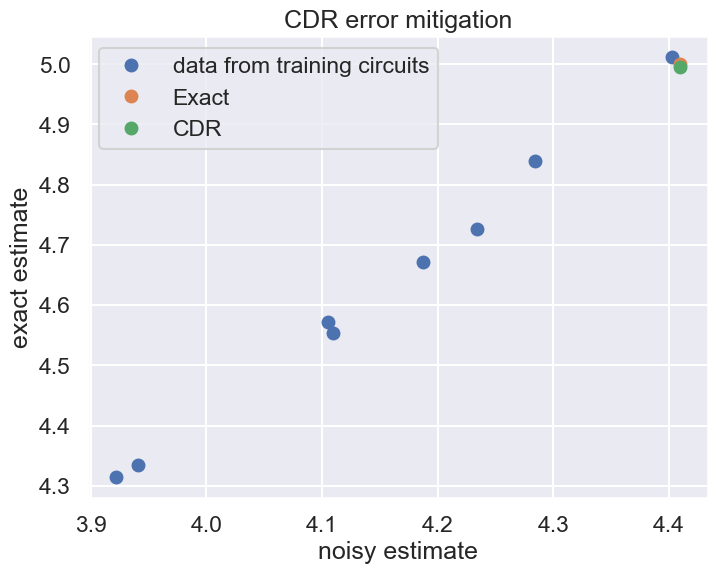

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("talk")
plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(noisy_estimates, exact_estimates, "o", label="data from training circuits")
plt.plot(
    [noisy_estimator(op, state).value.real], [noiseless_estimator(op, state).value.real], "o",
    label="Exact"
)
plt.plot(
    [noisy_estimator(op, state).value.real], [cdr_estimator(op, state).value.real], "o",
    label="CDR"
)
plt.xlabel("noisy estimate")
plt.ylabel("exact estimate")
plt.title("CDR error mitigation")
plt.legend()
plt.show()

### Create the CDR estimator

You can also create a CDR estimator that performs CDR behind the scenes. Once it's created, you can use it as a `QuantumEstimator`, which accepts `Estimatable` and `~QuantumState` and returns `Estimate`.

In [ ]:
from quri_parts.algo.mitigation.cdr import create_cdr_estimator

cdr_estimator = create_cdr_estimator(
    noisy_estimator=noisy_concurrent_estimator,
    exact_estimator=noiseless_concurrent_estimator,
    regression_method=poly_regression,
    num_training_circuits=10,
    fraction_of_replacement=0.5
)

estimate = cdr_estimator(op, state)
estimate

_Estimate(value=5.054745806576952, error=nan)